# Refactor

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm,kstest,shapiro,t
import pylab
import scipy
import time
import warnings
import seaborn as sns

In [2]:
data = pd.read_csv("problem1.csv")

In [3]:
#matrix generated
def generate_pd_matrix(n):
  corr = np.full((n,n),0.9)
  np.fill_diagonal(corr, 1) 
  return corr

def generate_psd_matrix(n):
  corr = generate_pd_matrix(n)
  corr[0,1] = 1.0
  corr[1,0] = 1.0 
  return corr

def generate_nonpsd_matrix(n):
  corr = generate_pd_matrix(n)
  corr[0,1] = 0.7357
  corr[1,0] = 0.7357 
  return corr

In [4]:
#cov and weighted cov
def weighted_pair(x, y, weight):
  n = len(weight)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  cov = 0
  for i in range(n):
    cov += weight[n - 1 - i]*(x[i] - mean_x) * (y[i] - mean_y)
  return cov

def calculate_weight(lamb, df):
  df = pd.DataFrame(df)
  X = df.index.values
  weight = [(1-lamb)*lamb**(i-1) for i in X]
  weight_adjust = [weight[i]/sum(weight) for i in X]
  return weight_adjust

def cal_weighted_cov_mat(df, weights):
  df1 = np.matrix(df).T
  dev = df1 - df1.mean(axis=1)
  #weights = weights[lambda_index]
  cov = dev @ np.diag(weights) @ dev.T
  return cov

In [5]:
A = generate_pd_matrix(10)
adjusted_weights = calculate_weight(0.9, A)
cov_matrix = cal_weighted_cov_mat(A, adjusted_weights)
cov_matrix

matrix([[ 1.32827195e-03, -1.91714587e-04, -1.77896528e-04,
         -1.65460274e-04, -1.54267646e-04, -1.44194281e-04,
         -1.35128252e-04, -1.26968826e-04, -1.19625343e-04,
         -1.13016208e-04],
        [-1.91714587e-04,  1.20544475e-03, -1.62543129e-04,
         -1.50106875e-04, -1.38914247e-04, -1.28840882e-04,
         -1.19774853e-04, -1.11615427e-04, -1.04271944e-04,
         -9.76628087e-05],
        [-1.77896528e-04, -1.62543129e-04,  1.09490028e-03,
         -1.36288816e-04, -1.25096188e-04, -1.15022822e-04,
         -1.05956793e-04, -9.77973676e-05, -9.04538843e-05,
         -8.38447493e-05],
        [-1.65460274e-04, -1.50106875e-04, -1.36288816e-04,
          9.95410249e-04, -1.12659934e-04, -1.02586569e-04,
         -9.35205400e-05, -8.53611141e-05, -7.80176308e-05,
         -7.14084959e-05],
        [-1.54267646e-04, -1.38914247e-04, -1.25096188e-04,
         -1.12659934e-04,  9.05869224e-04, -9.13939407e-05,
         -8.23279119e-05, -7.41684860e-05, -6.682500

In [6]:
#psd fixed
def chol_psd(sigma):
  L = np.full(sigma.shape, 0.0, dtype='float64')
  n = L.shape[1]
  for j in range(n):
    diag_val = sigma[j,j] - L[j,:j] @ L[j,:j].T
    if -1e-8 <= diag_val <= 0:
      diag_val = 0.0
    elif diag_val < -1e-8:
      raise ValueError("The matrix is not positive semi-definite!")
    L[j,j] = np.sqrt(diag_val)
    if L[j,j] == 0:
      continue
    for i in range(j+1, n):
      L[i, j] = (sigma[i,j] - L[i,:j] @ L[j,:j].T) / L[j, j] 
  return np.matrix(L)

def near_psd(A):
  eigen_val, eigen_vec = np.linalg.eigh(A)
  eigen_val[eigen_val < 0] = 0.0
  t = 1 / (np.dot(eigen_vec**2, eigen_val))
    
  sqrt_scaling_matrix = np.diagflat(np.sqrt(t))
  sqrt_eigen_val_matrix = np.diagflat(np.sqrt(eigen_val))

  temp = np.dot(sqrt_scaling_matrix, eigen_vec)
  B = np.dot(temp, sqrt_eigen_val_matrix)
  C = np.dot(B, B.T)
  return C

def cal_Frobenius_norm(A):
  n = len(A)
  norm = 0
  for i in range(n):
    for j in range(n):
      norm += A[i][j]**2
  return norm

def cal_projection_u(A):
  proj_u = A.copy()
  np.fill_diagonal(proj_u,1)
  return proj_u

def cal_projection_s(A):
  eigen_val, eigen_vec = np.linalg.eigh(A)
  eigen_val[eigen_val<0] = 0
  eigen_matrix = np.diagflat(eigen_val)
  temp = np.dot(eigen_vec, eigen_matrix)
  proj_s = np.dot(temp, eigen_vec.T)
  return proj_s

def Higham_near_psd(A):
  S = 0
  Y = A
  gamma_lag = 1.7976931348623157e+308
  iteration = 10000
  tolerance = 1e-10
  for i in range(iteration):
    R = Y - S
    X = cal_projection_s(R)
    S = X - R
    Y = cal_projection_u(X) 
    gamma = cal_Frobenius_norm(Y - A)
    if abs(gamma - gamma_lag)< tolerance:
      break
    gamma_lag = gamma
  return Y

def check_psd_matrix(A):
  eigen_val, eigen_vec = np.linalg.eigh(A)
  for i in range(0, len(eigen_val)):
    if eigen_val[i] < -1e-8:
      print("The matrix is non-PSD!")
      break
  print("The matrix is PSD!")
  return

In [7]:
A = generate_nonpsd_matrix(5)
B = near_psd(A)
check_psd_matrix(B)

The matrix is PSD!


In [8]:
#simulation method
from scipy.stats import norm, t,spearmanr
import scipy.optimize as optimize
def simulate_path(method, start_price, sigma, sample_size):
  return0 = scipy.stats.norm(0, sigma).rvs(sample_size)
  price_arr = []
  if method == "Classical":
    for i in range(0, sample_size):
      price = start_price + return0[i]
      price_arr.append(price)
  elif method == "Arithemetic":
    for i in range(0, sample_size):
      price = start_price * (1 + return0[i])
      price_arr.append(price)
  elif method == "Geometric":
    for i in range(0, sample_size):
      price = start_price * np.exp(return0[i])
      price_arr.append(np.log(price))
  else:
    print("Wrong method!")
  return price_arr

def Return_norm_simulation(array, size):
  mu = array.mean()
  sig = array.std()
  simu_norm = norm.rvs(loc= mu,scale = sig,size = size)
  return simu_norm

def Return_T_params(array):
  def t_log_lik(par_vec, x):
    lik = -np.log(t(df=par_vec[0], loc=par_vec[1], scale=par_vec[2]).pdf(x)).sum()
    return lik
  cons = ({'type': 'ineq', 'fun': lambda x: x[0] - 2},{'type': 'ineq', 'fun': lambda x: x[2]})
  df, mean, scale = optimize.minimize(fun=t_log_lik,x0=[2, np.array(array).mean(), np.array(array).std()],constraints=cons,args=(np.array(array))).x
  return df, mean, scale

def copula_t_simulation(ret, nOfDarws):
  n = ret.shape[1]
  stock_cdf = pd.DataFrame()
  t_params = []

  for col in ret.columns:
    ret[col] -= ret[col].mean()
    df, mean, scale = Return_T_params(ret[col])
    t_params.append([df, mean, scale])
    stock_cdf[col] = t.cdf(ret[col], df=df, loc=mean, scale=scale)

  Corr_spearman = spearmanr(stock_cdf)[0]
  cholesky = chol_psd(Corr_spearman)
  simuNormal = pd.DataFrame(norm.rvs(size=(n, nOfDarws)))
  simulatedT = (cholesky @ simuNormal).T
  Simu_data = pd.DataFrame()
  for i in range(n):
    simu = norm.cdf(simulatedT.iloc[:, i])
    Simu_data[ret.columns[i]] = t.ppf(simu, df=t_params[i][0], loc=t_params[i][1], scale=t_params[i][2])

  return Simu_data

In [ ]:
simulate_path("Geometric", 100, 0.1, 10000)

In [29]:
#VaR Calculation
from scipy.stats import norm,t

def simulate_normal(df, alpha, sample_size):
  sigma = df.std()
  normal = np.random.normal(0,sigma,size=sample_size)
  VaR = -np.percentile(normal, alpha)
  print(f"Normal distribution VaR: {round(VaR*100,2)}%")
  return VaR, normal

def simulate_EW(df, lambda0, alpha, sample_size):
  temp = df.reset_index()
  adj_weights = calculate_weight(lambda0, temp)
  sigma = np.sqrt(weighted_pair(df.values, df.values, adj_weights))
  Weighted_normal = np.random.normal(0, sigma, 10000)
  VaR = -np.percentile(Weighted_normal,5)
  print(f"Exponentially Weighted Normal VaR: {round(VaR*100,2)}%")
  return VaR, Weighted_normal

def MLE_t(array):
  def t_log_lik(par_vec, x):
    lik = -np.log(t(df = par_vec[0],loc=par_vec[1],scale = par_vec[2]).pdf(x)).sum()
    return lik
  cons = ({'type': 'ineq', 'fun': lambda x: x[0] - 2},{'type': 'ineq', 'fun': lambda x: x[2]})
  df, mean, scale = optimize.minimize(fun=t_log_lik, x0=[2, np.array(array).mean(), np.array(array).std()], constraints=cons, args=(np.array(array))).x
  return df, mean, scale

def simulate_MLE_t(df, alpha, sample_size):
  t_params = MLE_t(df)
  simulation_t =  t.rvs(df = t_params[0], loc = t_params[1], scale = t_params[2], size = sample_size)
  VaR = -np.percentile(simulation_t,alpha)
  print(f"T distribution VaR: {round(VaR*100,2)}%")
  return VaR, simulation_t

def simulate_history(df, alpha):
  VaR = -np.percentile(df,5)
  print(f"Historic Simulation VaR: {round(VaR*100,2)}%")
  return VaR


In [38]:
def show_simulation_results1(df, lambda0, alpha, sample_size):
  Normal_VaR, Normal_set = simulate_normal(df, alpha, sample_size)
  Weighted_Normal_VaR, Weighted_set = simulate_EW(df, lambda0, alpha, sample_size)
  MLE_t_VaR, t_set = simulate_MLE_t(df, alpha, sample_size)
  History_VaR = simulate_history(df, alpha)
  return

show_simulation_results1(data, 0.94, 5, 10000)

Normal distribution VaR: 8.03%
Exponentially Weighted Normal VaR: 8.75%
T distribution VaR: 7.83%
Historic Simulation VaR: 7.6%


In [66]:
#ES Calculation
def ES(ret_arr, alpha):
  VaR_t = -np.percentile(ret_arr, alpha*100)
  return_before_alpha = ret_arr[ret_arr < -VaR_t]
  ES = return_before_alpha.mean()
  print(f"Expected Shortfall: {round(-ES*100,2)}%")
  return -ES

In [15]:
#test in the below cell

Expected Shortfall: 11.68%


# Question1

In [67]:
normal_results = simulate_normal(data, 5, 10000)
normal = Return_norm_simulation(data, 10000)
normal_es = ES(normal, 0.05)

Normal distribution VaR: 8.12%
Expected Shortfall: 10.2%


In [68]:
t_results = simulate_MLE_t(data, 5, 10000)
t_es = ES(t_results[1], 0.05)

T distribution VaR: 7.52%
Expected Shortfall: 11.22%


In [71]:
def show_es_results(data, normal_results, normal_es, t_results, t_es):
  fig, axes = plt.subplots(figsize=(18,5))
  axes.axvline(x = -normal_results[0], linestyle='dashed', alpha=0.5)
  axes.text(x= -normal_results[0], y=12, s='VaR-Normal', alpha=0.7, color='#334f8d')
  axes.axvline(x = -normal_es, linestyle='dashed', alpha=0.5)
  axes.text(x= -normal_es, y=11, s='ES-Normal', alpha=0.7, color='#334f8d')

  axes.axvline(x = -t_results[0], linestyle='dashed', alpha=0.5, color='r')
  axes.text(x= -t_results[0], y=8, s='VaR-T', alpha=0.7, color='r')
  axes.axvline(x = -t_es, linestyle='dashed', alpha=0.5, color='r')
  axes.text(x= -t_es, y=7, s='ES-T', alpha=0.7, color='r')

  sns.histplot(data, binrange = (-.2,.2),binwidth = 0.01,stat='density',ax=axes, label='Historical', color='b', alpha=0.5)

  sns.distplot(normal_results[1], ax=axes, hist=False, label='Normal')
  sns.distplot(t_results[1], ax=axes, hist=False, label='T')

  plt.xlim(-0.3, 0.3)
  axes.legend()
  return

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


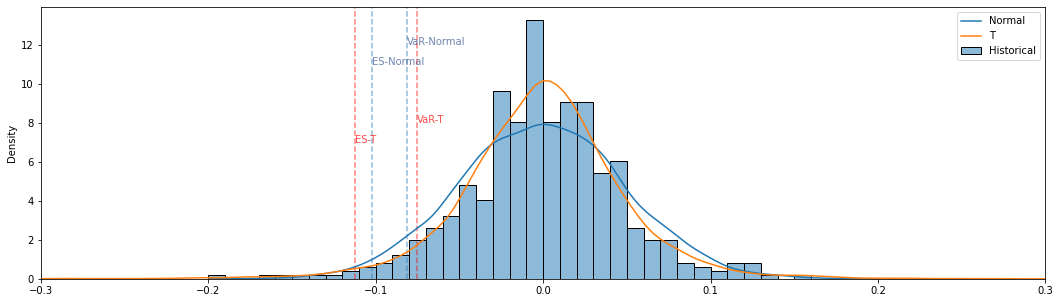

In [72]:
show_es_results(data, normal_results, normal_es, t_results, t_es)

# Question2

In [ ]:
#all refactoring is in the first part

# Question3

In [84]:
#import and modify data
portfolio = pd.read_csv("portfolio.csv")
portfolio[portfolio["Portfolio"]=="A"]
total = portfolio.groupby('Stock').sum('Holding')
total['Portfolio'] = 'total'
total.reset_index(inplace=True)
portfolio = portfolio.append(total)

prices = pd.read_csv("DailyPrices.csv",index_col=0)
return_set = prices.pct_change().dropna()
current = pd.DataFrame({"Price":prices.iloc[-1]})

In [94]:
def show_portfolio_results(portfolio, prices, return_set, current, sample_size):
  title = ["A","B","C","Total"]
  VaR_simu = []
  ES_simu = []
  VaR_his = []
  ES_his = []
  i=0
  
  fig, axes = plt.subplots(2, 2, figsize=(18, 12))
  for port_name, port_data in portfolio.groupby('Portfolio'):
    port_data = port_data.set_index('Stock')
    port_data = port_data.join(current.loc[port_data.index])
    port_data['Value'] = port_data['Holding'] * port_data['Price']

    port_value = port_data['Value'].sum()
    
    
    SimuPortfolio_ret = return_set[port_data.index]
    ret_MC = copula_t_simulation(SimuPortfolio_ret, sample_size)
    
    # calculate the profit&loss based on the simulated return
    profitLoss=ret_MC*port_data['Value']
    Portfolio_Loss = profitLoss.sum(axis=1)
    
    # calculate the simulated VaR
    VaR = simulate_normal(Portfolio_Loss, 5, sample_size)
    VaR_simu.append(VaR[0])
    
    # calculate the simulated ES
    ES_p = ES(Portfolio_Loss, 0.05)
    ES_simu.append(ES_p)
    
    # calculate the historical return
    his_return=port_data['Value']*return_set[port_data.index]
    his_profitloss = his_return.sum(axis=1)
    
    # calculate the historical VaR
    VaR_h = simulate_normal(his_profitloss, 5, sample_size)
    VaR_his.append(VaR_h[0])
    
    # calculate the historical ES
    ES_h = ES(his_profitloss, 0.05)
    ES_his.append(ES_h)
    
    # plot distributions
    ax = axes[i//2][i%2]
    
    sns.histplot(his_profitloss, ax=ax, stat='density', label='Historical Return')
    sns.distplot(Portfolio_Loss, ax=ax, hist=False, label='Simulated Return',color = 'r')
    ax.set_title(f"Portfolio {title[i]}")
    ax.set_xlabel("Portfolio Value")
    ax.legend()
    
    # plot VaR
    ret, ret_density = ax.lines[0].get_data()
    #ax.fill_between(ret, ret_density, where=(ret<VaR_h), color='r', alpha=0.5)
    ax.axvline(x = -ES_p, linestyle='dashed', alpha=0.5)
    ax.text(x=-ES_p, y=0.00004, s='Expected shortfall', fontsize=12,alpha=0.7, color='#334f8d',horizontalalignment='center')
    i+=1

  
  results = round(pd.DataFrame({"MC VaR":VaR_simu,
             "MC ES":ES_simu,
             "Historical VaR":VaR_his,
             "Historical ES":ES_his},index =title).T,2)
  return results



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:6315: RuntimeWarning: overflow encountered in power
  / (np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


Normal distribution VaR: 628260.5%
Expected Shortfall: 815796.03%
Normal distribution VaR: 592057.15%
Expected Shortfall: 762292.8%


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Normal distribution VaR: 466774.98%
Expected Shortfall: 592640.62%
Normal distribution VaR: 467630.4%
Expected Shortfall: 723108.07%


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Normal distribution VaR: 339331.24%
Expected Shortfall: 494109.84%
Normal distribution VaR: 376838.17%
Expected Shortfall: 488131.69%


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:6315: RuntimeWarning: overflow encountered in power
  / (np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log

Normal distribution VaR: 1505317.61%
Expected Shortfall: 1975965.14%
Normal distribution VaR: 1461922.31%
Expected Shortfall: 1973532.57%


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


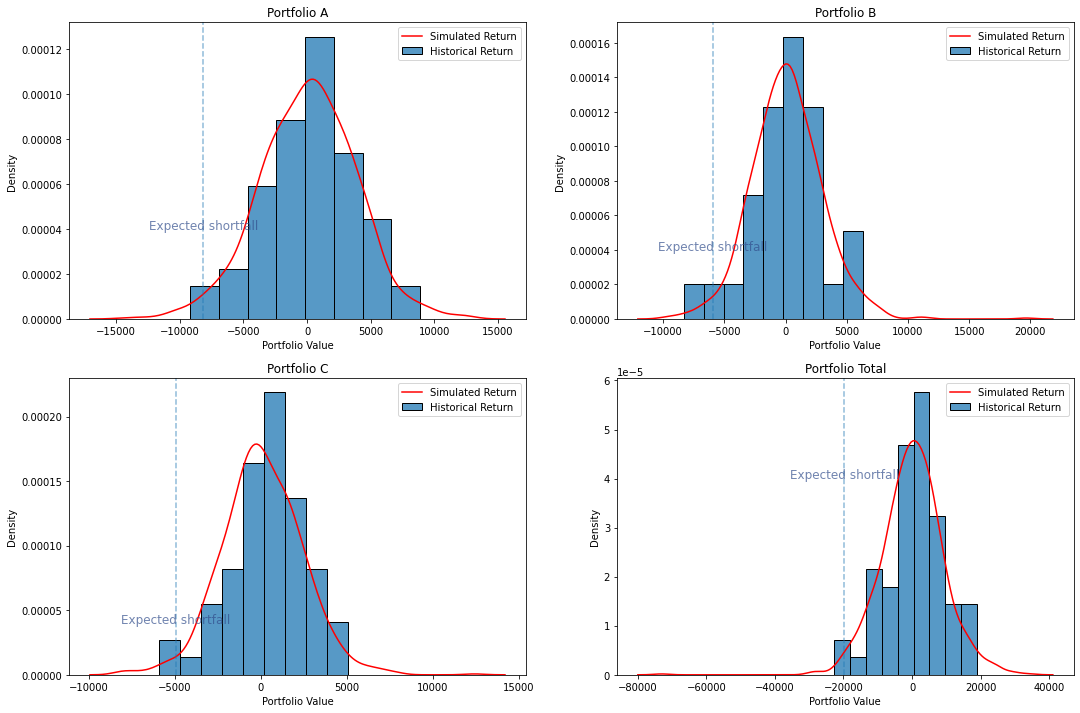

In [95]:
results = show_portfolio_results(portfolio, prices, return_set, current, 1000)

In [96]:
results

,A,B,C,Total
MC VaR,6282.60,4667.75,3393.31,15053.18
MC ES,8157.96,5926.41,4941.10,19759.65
Historical VaR,5920.57,4676.30,3768.38,14619.22
Historical ES,7622.93,7231.08,4881.32,19735.33
